# House Prices: Exploración y visualización.

#### *Álvaro Sánchez Castañeda*

Haremos una breve exploración de los datos: https://www.kaggle.com/c/house-prices-advanced-regression-techniques. Muchos de las ordenes que daremos se haran sin hacer uso de la libreria de Data Frames, de modo que pueden ser algo lentas.

- Resumen:
    - Definimos una funciones que muestren **histogramas** y **diagramas de barras**.
    - Calcularemos matrices de **correlaciones**.
    - Para cada una de las variables:
   
        - **Numéricas**:
            - Representaremos un **histograma**.
            - Presentaremos algunas medidas estadisticas.
        - **Categóricas**:
            - Representaremos un **diagrama de barras**.

## Inicializamos Spark y cargamos datos y librerias

In [1]:
#CARGAMOS
import sys

spark_path = "C:/Users/AlvaroSanchez91/Apps/spark-2.1.0-bin-hadoop2.7"

sys.path.append(spark_path + '/python')
sys.path.append(spark_path + '/python/lib/py4j-0.10.4-src.zip')

from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName("nb06") \
    .getOrCreate()
    
#DATOS
path = "D:/Ciencia de Datos/kaggle/House Prices. Advanced regression techniques/train.csv"
datos = spark.read.csv(path, header=True, inferSchema=True,nullValue= 'NA')

columnas=datos.columns

#LIBRERIAS
import math
import numpy
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pyspark.sql.functions import col, count, mean, min as agg_min ,max as agg_max, sum as agg_sum
from pyspark.sql.functions import lit
from pyspark.sql.types import IntegerType, DoubleType, StringType
from pyspark.mllib.linalg import Vectors
from pyspark.sql.functions import  udf
from pyspark.mllib.stat import Statistics 

### Definición histogramas y diagramas de barras

Definiremos una serie de funciones con el objetivo de representar graficamente histogramas y diagramas de barras.

In [2]:

#VARIABLES NUMERICAS Y CATEGORICAS
#Necesario para calcular los margenes de las variables numéricas.
tipos=dict(datos.dtypes)
var_num=[c for c in tipos if tipos[c]!='string']
var_cat=[c for c in tipos if tipos[c]=='string']

#MIN Y MAX VARIABLES NUMERICAS.
#Limitan el intervalo en el que haremos cortes para representar el histograma.
exprs = [agg_min(col(c)).alias(c) for c in var_num]
min_dict=datos.agg(*exprs).collect()[0].asDict()

exprs = [agg_max(col(c)).alias(c) for c in var_num]
max_dict=datos.agg(*exprs).collect()[0].asDict()

##############################
#          CUT 
##############################

#Definimos funciones que dividan nuestros datos intervalos.
#Podemos indicar cuantos cortes queremos dar en breaks.
def cut_num(x,c,breaks=10):
    m=min_dict[c]#Sería conveniente introducirlo como parámetro de la función.
    M=max_dict[c]
    cuts=[math.floor(m+i*(M-m)/breaks) for i in range(breaks)]
    cuts=sorted(list(set(cuts)))#Eliminamos cortes duplicados.
    cuts_M=cuts + [M]
    for i in range(len(cuts)-1):
        if x<= cuts[i+1]:
            return (str(cuts[i])+'-'+str(cuts[i+1]))
    return (str(cuts[-1])+'-'+str(math.ceil(M)))

#User defined function para discretizar los datos en los rdds.
def cut_df(c,breaks=10):
    return (udf(lambda val:str(cut_num(val,c,breaks)), StringType()))

#################################################
#                  PLOTS
#################################################

#plot_freqs recibe categorias y valores y los representa.
def plot_freqs(categories, values, max_y,title):    
    plt.bar(range(len(categories)), values, align='center')
    plt.xticks(range(len(categories)), categories)
    plt.suptitle(title)
    plt.show()
    
#BAR PLOT
#Indicando una tabla de datos y una variable categórica, representamos un diagrama de barras.

def bar_plot(c,title,data=datos):
    freq_row=data.groupBy(c).count().collect()
    freq_dic={r[c]:r['count'] for r in freq_row}
    #En caso de provenir de datos numericos, tratamos de ordenar para que quede un histograma.
    #Estos datos son de la forma 'int1-int2', usamos int1 para ordenar.
    try:
        freq_dic_key=sorted(freq_dic,key=lambda x: int(x.split('-')[0]))#Orden numérico.
    except:
        freq_dic_key=freq_dic.keys()
    freq_dic_val=[freq_dic[k] for k in freq_dic_key]
    plot_freqs(freq_dic_key,freq_dic_val,sum(freq_dic_val),title)

#HIST
#Indicando una tabla de datos, una variable numérica y el número de cortes, representamos un histograma.

def hist(c,data=datos,breaks=10):
    data=data.filter(data[c].isNotNull())#Eliminamos NAs.
    #Discretizaremos la variable mediante cut_df.
    bar_plot('cut',c,data.withColumn('cut',cut_df(c,breaks)(datos[c])))

## Correlaciones.

Solo se pueden calcular correlaciones entre variables numericas (para las categóricas se suelen hacer análisis de correspondencias...). Calculemos en primer lugar la matriz de correlaciones para nuestras variables numéricas, y en segundo lugar, carguemos los datos con variables categóricas transformadas (dummies) para calcular de nuevo la matriz de correlaciones.

Aun no podemos calcular correlaciones mediante la libreria de Data Frames de Spark, de modo que recurriremos a la **libraria mllib**. Necesitamos transformar nuestros datos.

In [3]:
#SELECCIONAMOS VARIABLES NUMÉRICAS.
datos_num=datos.select(var_num)
#CAMBIAMOS EL FORMATO.
datos_rdd = datos_num.rdd.map(Vectors.dense)
datos_rdd.first()

DenseVector([1.0, 854.0, 8.0, 2003.0, 196.0, 1.0, 61.0, 2.0, 0.0, 0.0, 548.0, 2003.0, 2.0, 8450.0, 856.0, 856.0, 0.0, 150.0, 706.0, 0.0, 60.0, 0.0, 0.0, 1710.0, 2.0, 0.0, 65.0, 7.0, 0.0, 1.0, 208500.0, 0.0, 1.0, 5.0, 3.0, 0.0, 2008.0, 2003.0])

#### Correlaciones variables numéricas.

In [4]:
pearson_corr = Statistics.corr(datos_rdd, method="pearson")
pearson_corr_df = pd.DataFrame(pearson_corr, index=var_num, columns=var_num)
pearson_corr_df

,KitchenAbvGr,2ndFlrSF,TotRmsAbvGrd,YearRemodAdd,MasVnrArea,Id,OpenPorchSF,GarageCars,3SsnPorch,BsmtFinSF2,...,ScreenPorch,BsmtFullBath,SalePrice,BsmtHalfBath,HalfBath,OverallCond,BedroomAbvGr,Fireplaces,YrSold,YearBuilt
KitchenAbvGr,1.000000,0.059306,0.256045,-0.149598,NaN,0.002951,-0.070091,-0.050634,-0.024600,-0.040751,...,-0.051613,-0.041503,-0.135907,-0.037944,-0.068263,-0.087001,0.198597,-0.123936,0.031687,-0.174800
2ndFlrSF,0.059306,1.000000,0.616423,0.140024,NaN,0.005590,0.208026,0.183926,-0.024358,-0.099260,...,0.040606,-0.169494,0.319334,-0.023855,0.609707,0.028942,0.502901,0.194561,-0.028700,0.010308
TotRmsAbvGrd,0.256045,0.616423,1.000000,0.191740,NaN,0.027239,0.234192,0.362289,-0.006683,-0.035227,...,0.059383,-0.053275,0.533723,-0.023836,0.343415,-0.057583,0.676620,0.326114,-0.034516,0.095589
YearRemodAdd,-0.149598,0.140024,0.191740,1.000000,NaN,-0.021998,0.226298,0.420622,0.045286,-0.067759,...,-0.038740,0.119470,0.507101,-0.012337,0.183331,0.073741,-0.040581,0.112581,0.035743,0.592855
MasVnrArea,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Id,0.002951,0.005590,0.027239,-0.021998,NaN,1.000000,-0.000477,0.016570,-0.046635,-0.005968,...,0.001330,0.002289,-0.021917,-0.020155,0.006784,0.012609,0.037719,-0.019772,0.000712,-0.012713
OpenPorchSF,-0.070091,0.208026,0.234192,0.226298,NaN,-0.000477,1.000000,0.213569,-0.005842,0.003093,...,0.074304,0.067341,0.315856,-0.025324,0.199740,-0.032589,0.093810,0.169405,-0.057619,0.188686
GarageCars,-0.050634,0.183926,0.362289,0.420622,NaN,0.016570,0.213569,1.000000,0.035765,-0.038264,...,0.050494,0.131881,0.640409,-0.020891,0.219178,-0.185758,0.086106,0.300789,-0.039117,0.537850
3SsnPorch,-0.024600,-0.024358,-0.006683,0.045286,NaN,-0.046635,-0.005842,0.035765,1.000000,-0.029993,...,-0.031436,-0.000106,0.044584,0.035114,-0.004972,0.025504,-0.024478,0.011257,0.018645,0.031355
BsmtFinSF2,-0.040751,-0.099260,-0.035227,-0.067759,NaN,-0.005968,0.003093,-0.038264,-0.029993,1.000000,...,0.088871,0.158678,-0.011378,0.070948,-0.032148,0.040229,-0.015728,0.046921,0.031706,-0.049107


Aparecen muchos valores perdidos, mejor recurrimos a los datos limpios y transformados para ver la correlaciones.

#### Correlaciones datos transformados.

In [5]:
#DATOS TRANSFORMADOS.
path = "HousePrices_num2_csv"
datos_num = spark.read.csv(path, header=True, inferSchema=True,nullValue= 'NA')

#CAMBIAMOS FORMATO.
datos_rdd = datos_num.rdd.map(Vectors.dense)

#CORRELACIONES.
pearson_corr = Statistics.corr(datos_rdd, method="pearson")
pearson_corr_df = pd.DataFrame(pearson_corr, index=datos_num.columns, columns=datos_num.columns)
pearson_corr_df

,MiscFeature_Shed,MiscFeature_Gar2,MiscFeature_TenC,MiscFeature_Othr,MiscFeature_real_NA,Street_Pave,Street_Grvl,Alley_Pave,Alley_Grvl,Alley_real_NA,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,GarageYrBlt_NA,SalePrice
MiscFeature_Shed,1.000000,-0.007597,-0.003395,-0.006794,-0.949504,-0.078737,0.078737,-0.018419,0.020368,-0.004269,...,0.015538,0.027522,0.030342,-0.006871,-0.011583,0.230508,-0.000884,0.046536,0.015528,NaN
MiscFeature_Gar2,-0.007597,1.000000,-0.000767,-0.001534,-0.214441,0.002661,-0.002661,-0.006864,0.033150,-0.021772,...,-0.021757,0.003806,-0.004280,-0.011844,-0.002616,0.635917,-0.003252,-0.006072,-0.009942,NaN
MiscFeature_TenC,-0.003395,-0.000767,1.000000,-0.000686,-0.095835,0.001189,-0.001189,-0.003067,-0.003833,0.004994,...,0.017676,-0.006657,-0.001913,0.139707,0.268276,0.063605,0.005367,-0.025243,-0.004443,NaN
MiscFeature_Othr,-0.006794,-0.001534,-0.000686,1.000000,-0.191769,0.002380,-0.002380,-0.006138,-0.007670,0.009993,...,0.031122,0.007440,-0.003828,0.026336,-0.002339,0.208897,0.017563,0.012884,0.031916,NaN
MiscFeature_real_NA,-0.949504,-0.214441,-0.095835,-0.191769,1.000000,0.073844,-0.073844,0.020599,-0.024864,0.006421,...,-0.017913,-0.027887,-0.027011,-0.009938,-0.014578,-0.408678,-0.002458,-0.043045,-0.018487,NaN
Street_Pave,-0.078737,0.002661,0.001189,0.002380,0.073844,1.000000,-1.000000,0.010646,0.013303,-0.017332,...,0.007357,-0.039828,0.006639,-0.006696,0.004057,-0.006645,0.016879,-0.018273,-0.031763,NaN
Street_Grvl,0.078737,-0.002661,-0.001189,-0.002380,-0.073844,-1.000000,1.000000,-0.010646,-0.013303,0.017332,...,-0.007357,0.039828,-0.006639,0.006696,-0.004057,0.006645,-0.016879,0.018273,0.031763,NaN
Alley_Pave,-0.018419,-0.006864,-0.003067,-0.006138,0.020599,0.010646,-0.010646,1.000000,-0.034308,-0.614247,...,0.117246,0.024385,0.001773,-0.017050,-0.010464,-0.012973,-0.029443,0.006732,-0.011689,NaN
Alley_Grvl,0.020368,0.033150,-0.003833,-0.007670,-0.024864,0.013303,-0.013303,-0.034308,1.000000,-0.767575,...,-0.024604,0.190622,-0.021395,0.010797,-0.013076,0.008215,-0.000363,-0.009355,0.094761,NaN
Alley_real_NA,-0.004269,-0.021772,0.004994,0.009993,0.006421,-0.017332,0.017332,-0.614247,-0.767575,1.000000,...,-0.055767,-0.166150,0.015756,0.002409,0.017035,0.001834,0.019169,0.003069,-0.067325,NaN


### Exploración variables numéricas.
Para cada una de las variables, representaremos un histograma y mostraremos el maximo, el minimo, la media y la desviación típica.

KitchenAbvGr
+-------+-------------------+
|summary|       KitchenAbvGr|
+-------+-------------------+
|  count|               1460|
|   mean| 1.0465753424657533|
| stddev|0.22033819838403076|
|    min|                  0|
|    max|                  3|
+-------+-------------------+



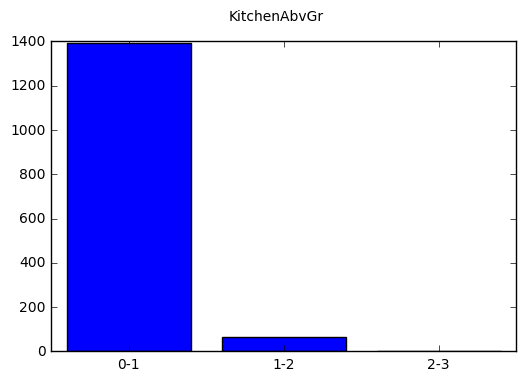

2ndFlrSF
+-------+------------------+
|summary|          2ndFlrSF|
+-------+------------------+
|  count|              1460|
|   mean|346.99246575342465|
| stddev|  436.528435886257|
|    min|                 0|
|    max|              2065|
+-------+------------------+



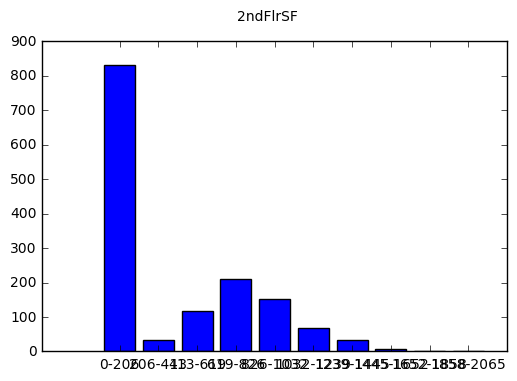

TotRmsAbvGrd
+-------+------------------+
|summary|      TotRmsAbvGrd|
+-------+------------------+
|  count|              1460|
|   mean| 6.517808219178082|
| stddev|1.6253932905840511|
|    min|                 2|
|    max|                14|
+-------+------------------+



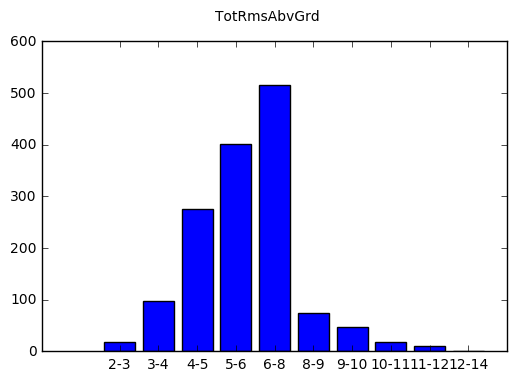

YearRemodAdd
+-------+------------------+
|summary|      YearRemodAdd|
+-------+------------------+
|  count|              1460|
|   mean|1984.8657534246574|
| stddev| 20.64540680770938|
|    min|              1950|
|    max|              2010|
+-------+------------------+



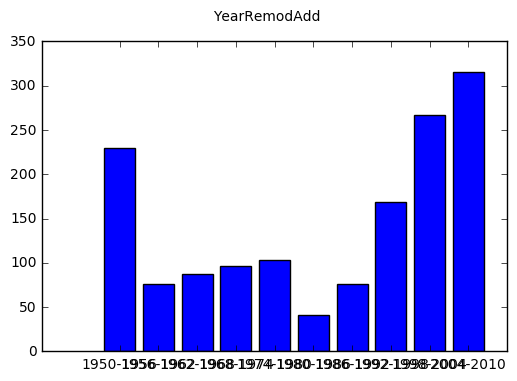

MasVnrArea
+-------+------------------+
|summary|        MasVnrArea|
+-------+------------------+
|  count|              1452|
|   mean|103.68526170798899|
| stddev|181.06620658721647|
|    min|                 0|
|    max|              1600|
+-------+------------------+



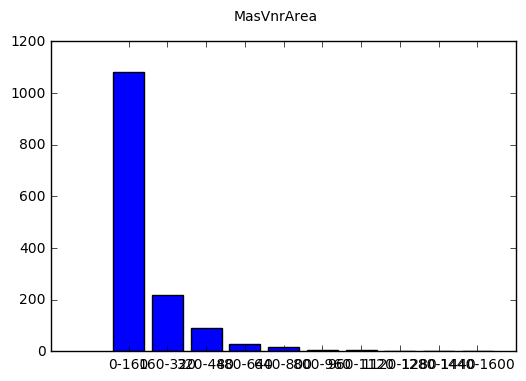

Id
+-------+-----------------+
|summary|               Id|
+-------+-----------------+
|  count|             1460|
|   mean|            730.5|
| stddev|421.6100093688479|
|    min|                1|
|    max|             1460|
+-------+-----------------+



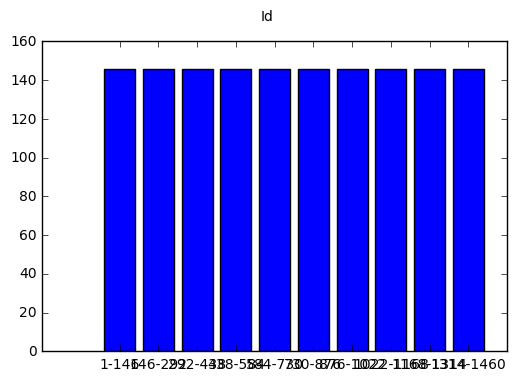

OpenPorchSF
+-------+-----------------+
|summary|      OpenPorchSF|
+-------+-----------------+
|  count|             1460|
|   mean|46.66027397260274|
| stddev| 66.2560276766497|
|    min|                0|
|    max|              547|
+-------+-----------------+



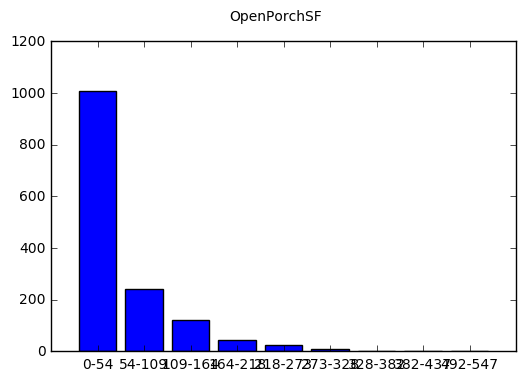

GarageCars
+-------+------------------+
|summary|        GarageCars|
+-------+------------------+
|  count|              1460|
|   mean|1.7671232876712328|
| stddev|0.7473150101111095|
|    min|                 0|
|    max|                 4|
+-------+------------------+



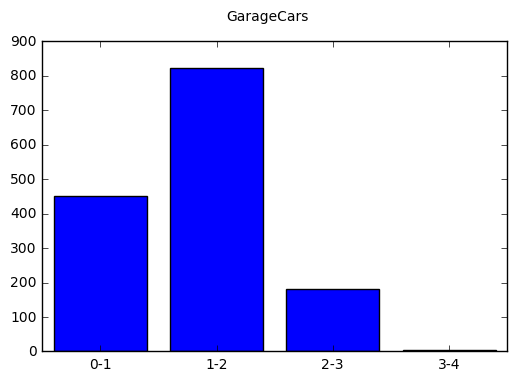

3SsnPorch
+-------+------------------+
|summary|         3SsnPorch|
+-------+------------------+
|  count|              1460|
|   mean|3.4095890410958902|
| stddev|29.317330556781872|
|    min|                 0|
|    max|               508|
+-------+------------------+



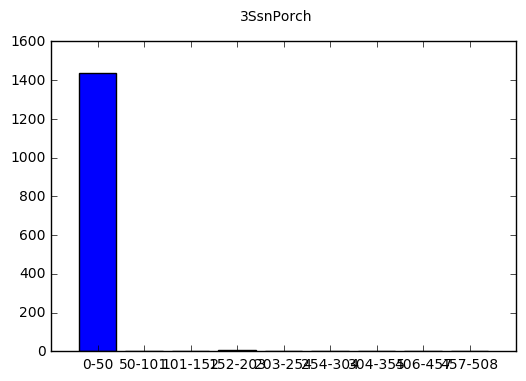

BsmtFinSF2
+-------+-----------------+
|summary|       BsmtFinSF2|
+-------+-----------------+
|  count|             1460|
|   mean|46.54931506849315|
| stddev|161.3192728065416|
|    min|                0|
|    max|             1474|
+-------+-----------------+



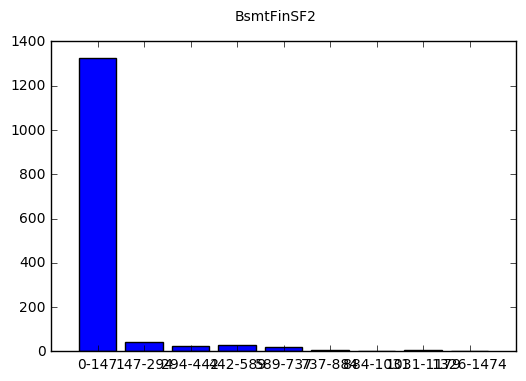

GarageArea
+-------+-----------------+
|summary|       GarageArea|
+-------+-----------------+
|  count|             1460|
|   mean|472.9801369863014|
| stddev|213.8048414533803|
|    min|                0|
|    max|             1418|
+-------+-----------------+



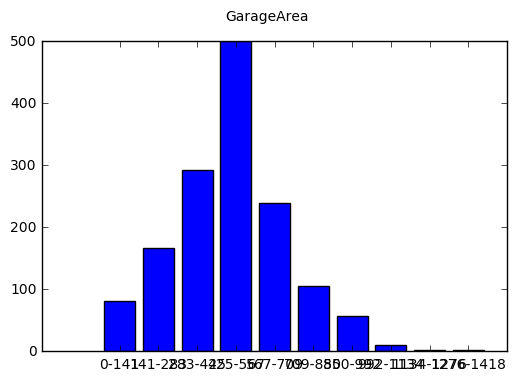

GarageYrBlt
+-------+------------------+
|summary|       GarageYrBlt|
+-------+------------------+
|  count|              1379|
|   mean|1978.5061638868744|
| stddev| 24.68972476859027|
|    min|              1900|
|    max|              2010|
+-------+------------------+



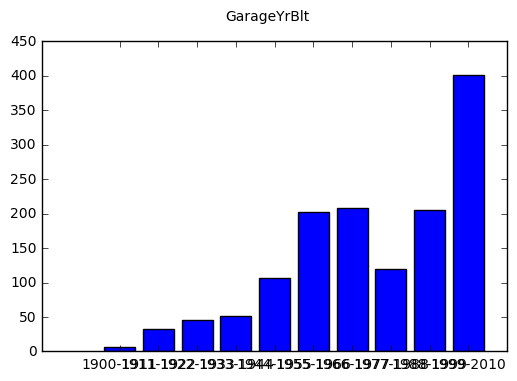

FullBath
+-------+------------------+
|summary|          FullBath|
+-------+------------------+
|  count|              1460|
|   mean|1.5650684931506849|
| stddev|0.5509158012954318|
|    min|                 0|
|    max|                 3|
+-------+------------------+



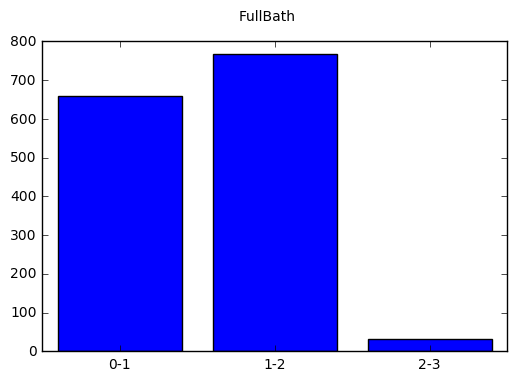

LotArea
+-------+------------------+
|summary|           LotArea|
+-------+------------------+
|  count|              1460|
|   mean|10516.828082191782|
| stddev|  9981.26493237915|
|    min|              1300|
|    max|            215245|
+-------+------------------+



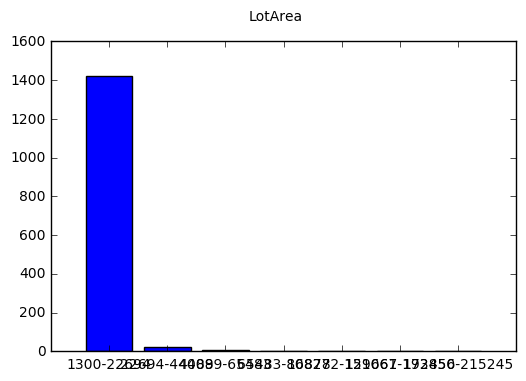

TotalBsmtSF
+-------+------------------+
|summary|       TotalBsmtSF|
+-------+------------------+
|  count|              1460|
|   mean|1057.4294520547944|
| stddev| 438.7053244594709|
|    min|                 0|
|    max|              6110|
+-------+------------------+



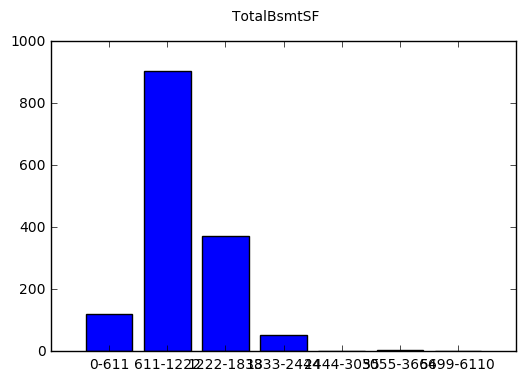

1stFlrSF
+-------+-----------------+
|summary|         1stFlrSF|
+-------+-----------------+
|  count|             1460|
|   mean|1162.626712328767|
| stddev|386.5877380410744|
|    min|              334|
|    max|             4692|
+-------+-----------------+



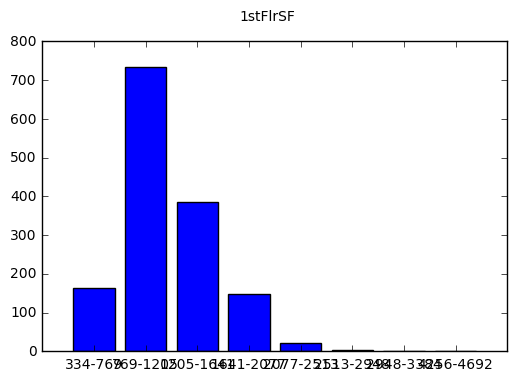

PoolArea
+-------+-----------------+
|summary|         PoolArea|
+-------+-----------------+
|  count|             1460|
|   mean|2.758904109589041|
| stddev|40.17730694453021|
|    min|                0|
|    max|              738|
+-------+-----------------+



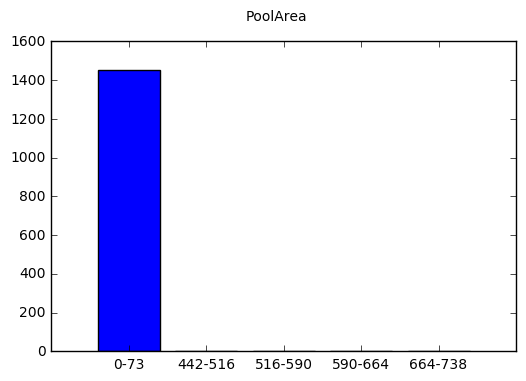

BsmtUnfSF
+-------+-----------------+
|summary|        BsmtUnfSF|
+-------+-----------------+
|  count|             1460|
|   mean|567.2404109589041|
| stddev|441.8669552924343|
|    min|                0|
|    max|             2336|
+-------+-----------------+



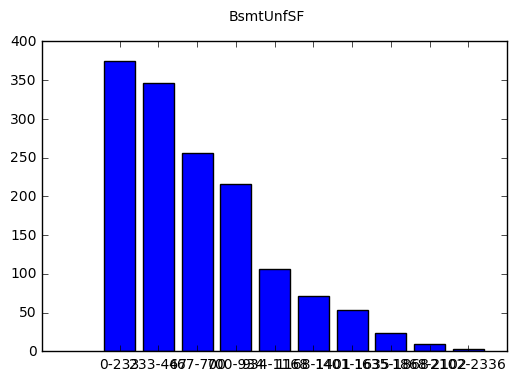

BsmtFinSF1
+-------+-----------------+
|summary|       BsmtFinSF1|
+-------+-----------------+
|  count|             1460|
|   mean|443.6397260273973|
| stddev|456.0980908409278|
|    min|                0|
|    max|             5644|
+-------+-----------------+



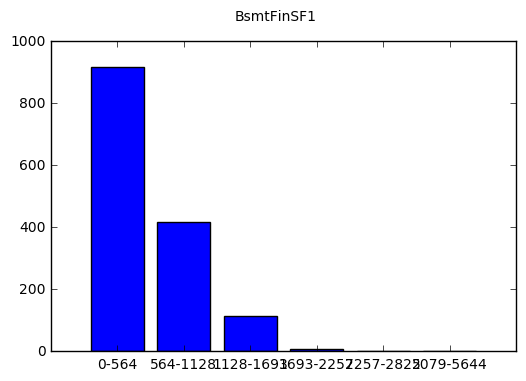

MiscVal
+-------+------------------+
|summary|           MiscVal|
+-------+------------------+
|  count|              1460|
|   mean|43.489041095890414|
| stddev| 496.1230244579441|
|    min|                 0|
|    max|             15500|
+-------+------------------+



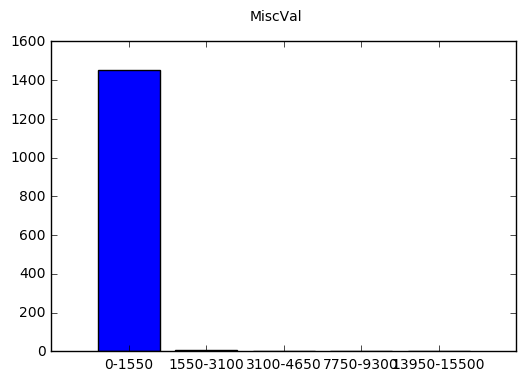

MSSubClass
+-------+------------------+
|summary|        MSSubClass|
+-------+------------------+
|  count|              1460|
|   mean|56.897260273972606|
| stddev| 42.30057099381045|
|    min|                20|
|    max|               190|
+-------+------------------+



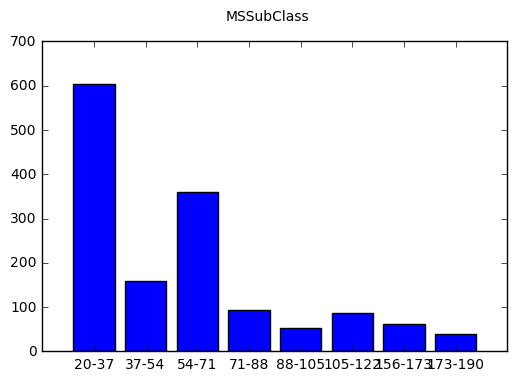

LowQualFinSF
+-------+-----------------+
|summary|     LowQualFinSF|
+-------+-----------------+
|  count|             1460|
|   mean|5.844520547945206|
| stddev|48.62308143352024|
|    min|                0|
|    max|              572|
+-------+-----------------+



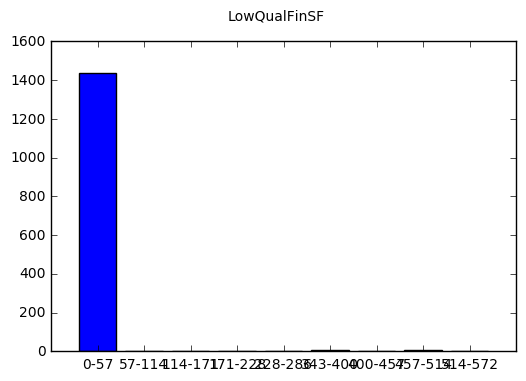

WoodDeckSF
+-------+------------------+
|summary|        WoodDeckSF|
+-------+------------------+
|  count|              1460|
|   mean|  94.2445205479452|
| stddev|125.33879435172422|
|    min|                 0|
|    max|               857|
+-------+------------------+



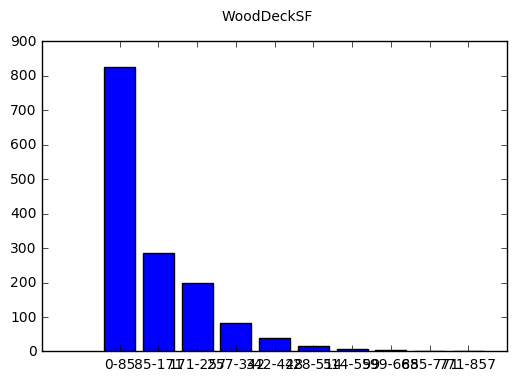

GrLivArea
+-------+-----------------+
|summary|        GrLivArea|
+-------+-----------------+
|  count|             1460|
|   mean|1515.463698630137|
| stddev|525.4803834232024|
|    min|              334|
|    max|             5642|
+-------+-----------------+



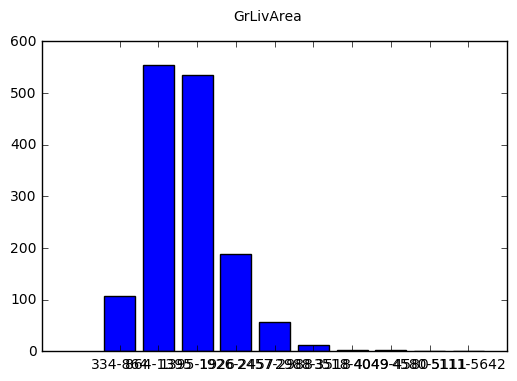

MoSold
+-------+------------------+
|summary|            MoSold|
+-------+------------------+
|  count|              1460|
|   mean| 6.321917808219178|
| stddev|2.7036262083595113|
|    min|                 1|
|    max|                12|
+-------+------------------+



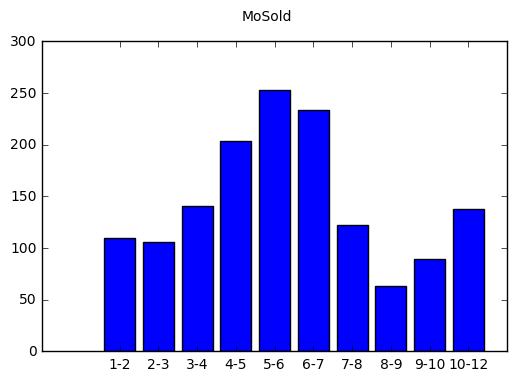

EnclosedPorch
+-------+------------------+
|summary|     EnclosedPorch|
+-------+------------------+
|  count|              1460|
|   mean|21.954109589041096|
| stddev| 61.11914860172857|
|    min|                 0|
|    max|               552|
+-------+------------------+



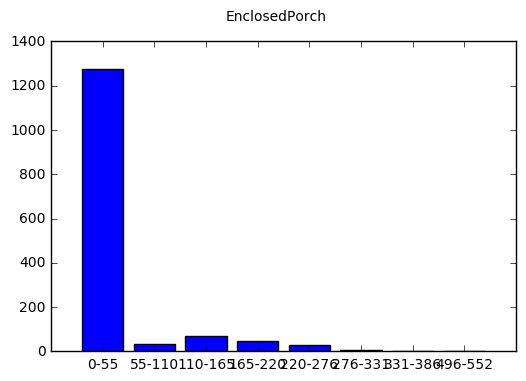

LotFrontage
+-------+-----------------+
|summary|      LotFrontage|
+-------+-----------------+
|  count|             1201|
|   mean|70.04995836802665|
| stddev|24.28475177448321|
|    min|               21|
|    max|              313|
+-------+-----------------+



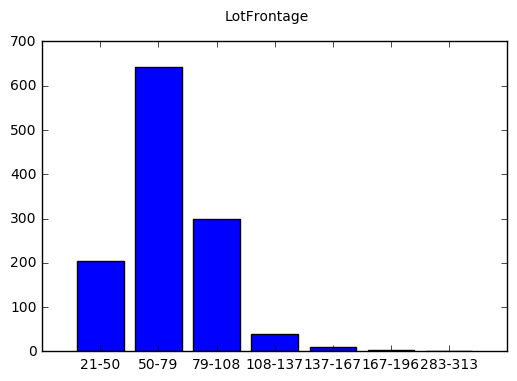

OverallQual
+-------+------------------+
|summary|       OverallQual|
+-------+------------------+
|  count|              1460|
|   mean|6.0993150684931505|
| stddev|1.3829965467415926|
|    min|                 1|
|    max|                10|
+-------+------------------+



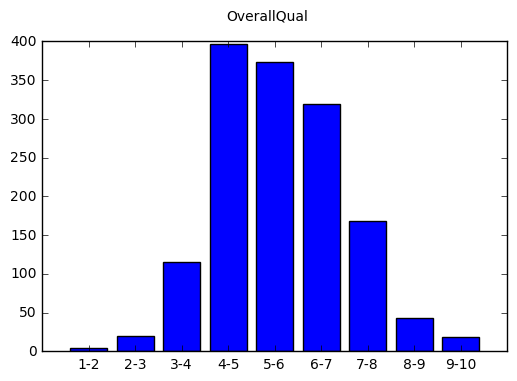

ScreenPorch
+-------+------------------+
|summary|       ScreenPorch|
+-------+------------------+
|  count|              1460|
|   mean|15.060958904109588|
| stddev| 55.75741528187416|
|    min|                 0|
|    max|               480|
+-------+------------------+



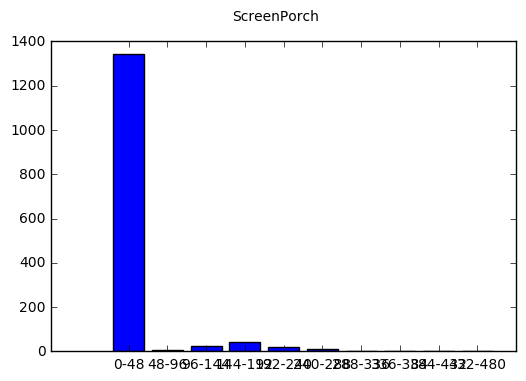

BsmtFullBath
+-------+-------------------+
|summary|       BsmtFullBath|
+-------+-------------------+
|  count|               1460|
|   mean|0.42534246575342466|
| stddev| 0.5189106060898061|
|    min|                  0|
|    max|                  3|
+-------+-------------------+



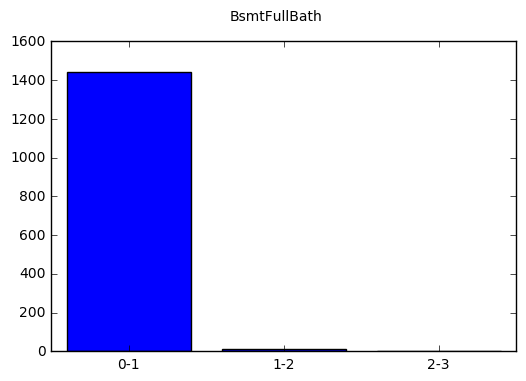

SalePrice
+-------+------------------+
|summary|         SalePrice|
+-------+------------------+
|  count|              1460|
|   mean|180921.19589041095|
| stddev| 79442.50288288663|
|    min|             34900|
|    max|            755000|
+-------+------------------+



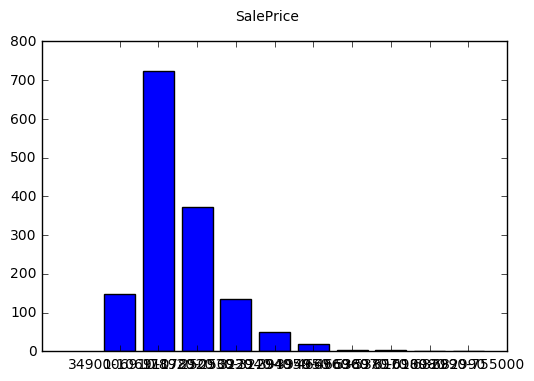

BsmtHalfBath
+-------+--------------------+
|summary|        BsmtHalfBath|
+-------+--------------------+
|  count|                1460|
|   mean|0.057534246575342465|
| stddev| 0.23875264627921197|
|    min|                   0|
|    max|                   2|
+-------+--------------------+



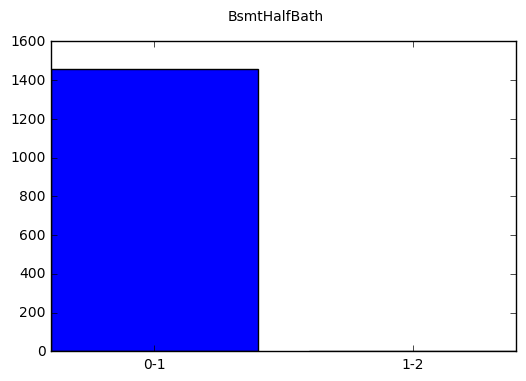

HalfBath
+-------+-------------------+
|summary|           HalfBath|
+-------+-------------------+
|  count|               1460|
|   mean|0.38287671232876713|
| stddev| 0.5028853810928912|
|    min|                  0|
|    max|                  2|
+-------+-------------------+



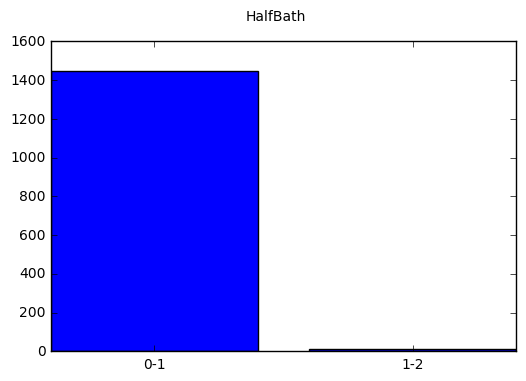

OverallCond
+-------+------------------+
|summary|       OverallCond|
+-------+------------------+
|  count|              1460|
|   mean| 5.575342465753424|
| stddev|1.1127993367127318|
|    min|                 1|
|    max|                 9|
+-------+------------------+



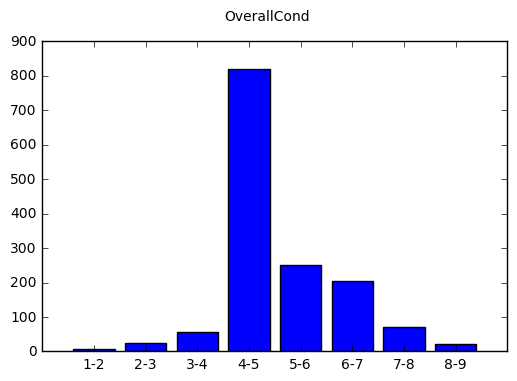

BedroomAbvGr
+-------+------------------+
|summary|      BedroomAbvGr|
+-------+------------------+
|  count|              1460|
|   mean|2.8664383561643834|
| stddev|0.8157780441442279|
|    min|                 0|
|    max|                 8|
+-------+------------------+



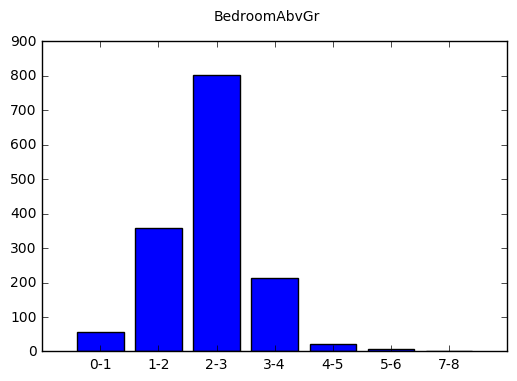

Fireplaces
+-------+------------------+
|summary|        Fireplaces|
+-------+------------------+
|  count|              1460|
|   mean| 0.613013698630137|
| stddev|0.6446663863122297|
|    min|                 0|
|    max|                 3|
+-------+------------------+



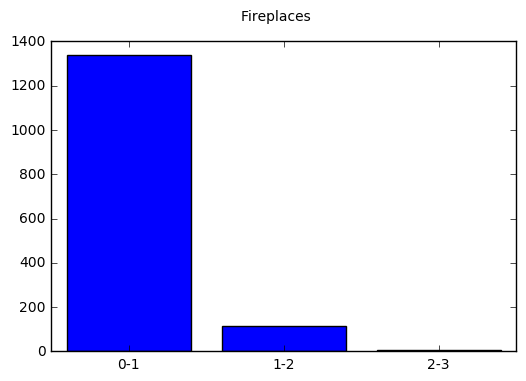

YrSold
+-------+------------------+
|summary|            YrSold|
+-------+------------------+
|  count|              1460|
|   mean|2007.8157534246575|
| stddev|1.3280951205521145|
|    min|              2006|
|    max|              2010|
+-------+------------------+



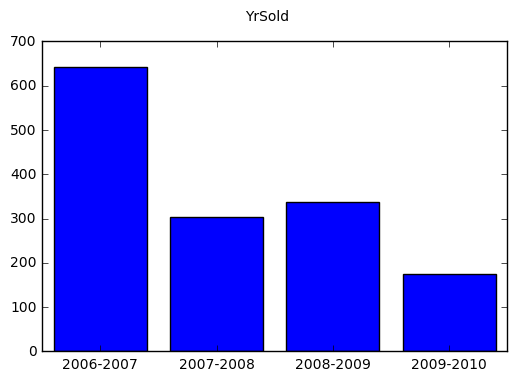

YearBuilt
+-------+------------------+
|summary|         YearBuilt|
+-------+------------------+
|  count|              1460|
|   mean| 1971.267808219178|
| stddev|30.202904042525294|
|    min|              1872|
|    max|              2010|
+-------+------------------+



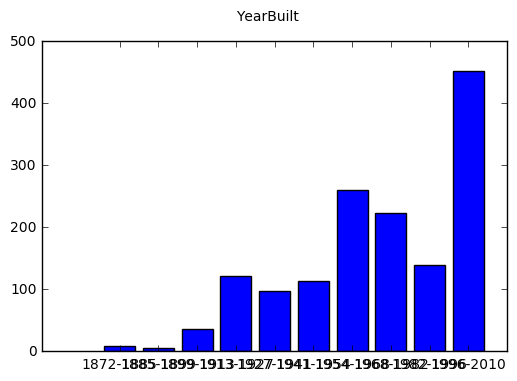

In [6]:
for c in var_num:
    print(c)
    datos.select(c).describe().show()
    hist(c,data=datos,breaks=10)

Se observan algunas variables a las que se les podría aplicar una transformación logarítmica.

### Exploración variables categóricas.
Para cada variable mostraremos un diagrama de barras.

BsmtQual


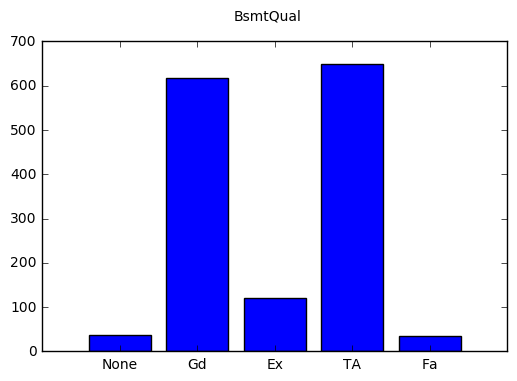

GarageCond


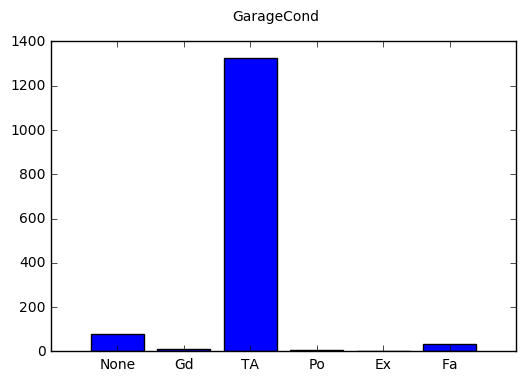

Exterior2nd


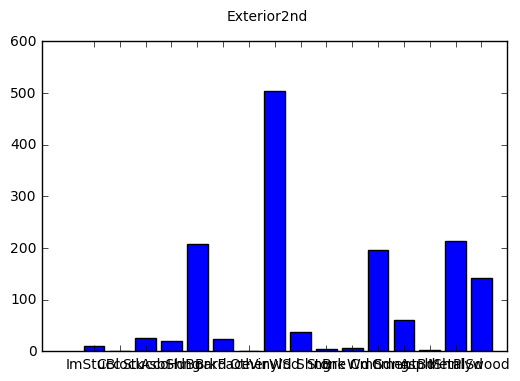

GarageType


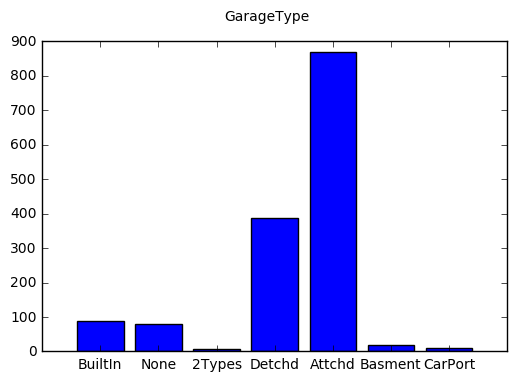

KitchenQual


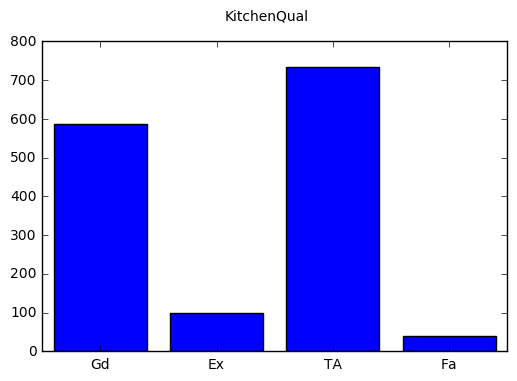

Condition2


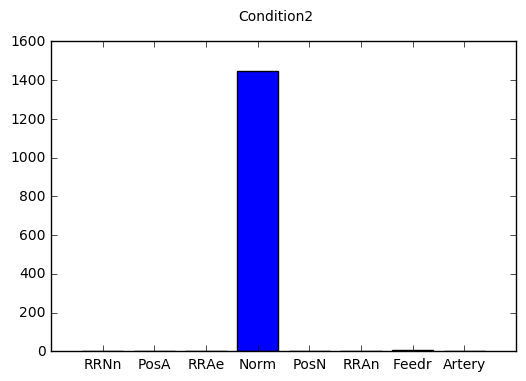

GarageFinish


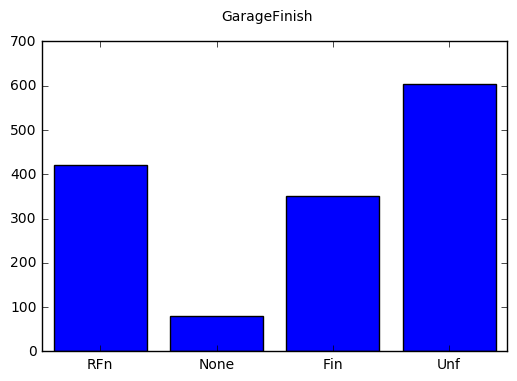

Street


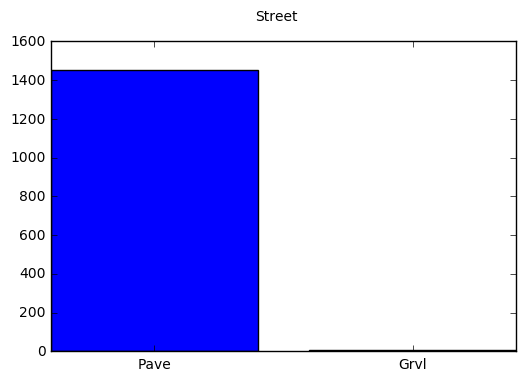

Electrical


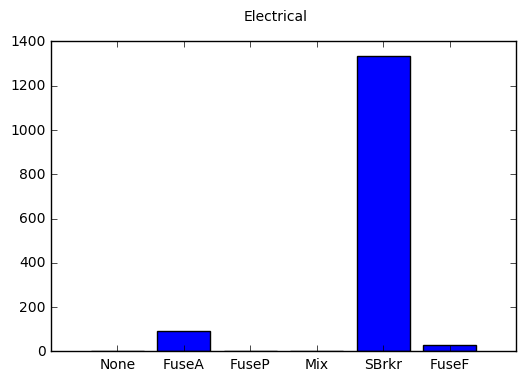

PoolQC


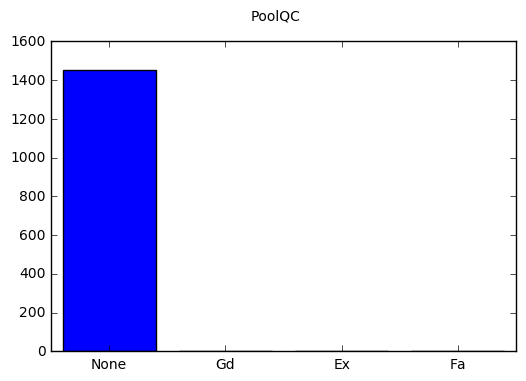

RoofStyle


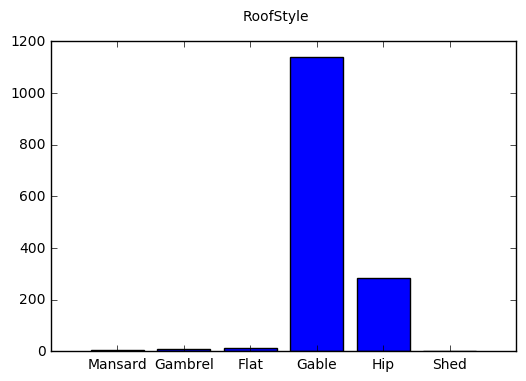

BsmtCond


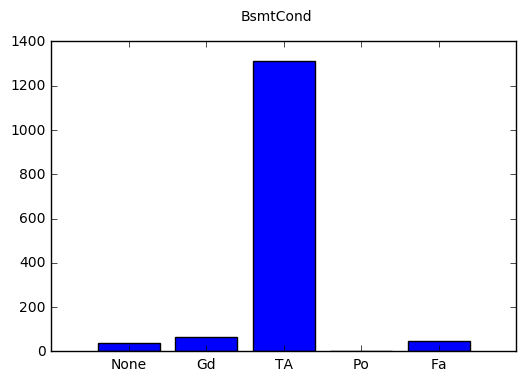

LandSlope


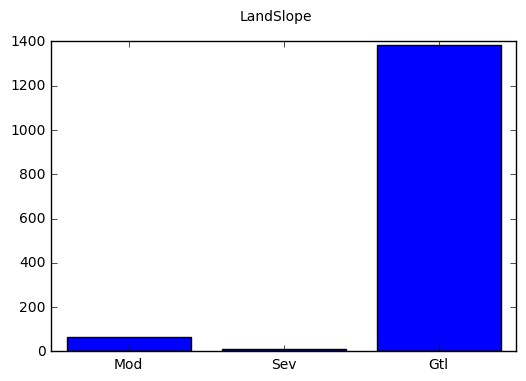

LotShape


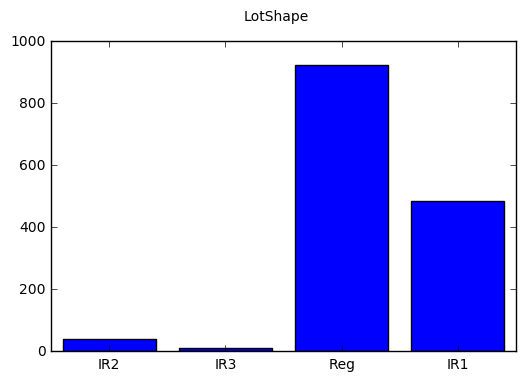

SaleType


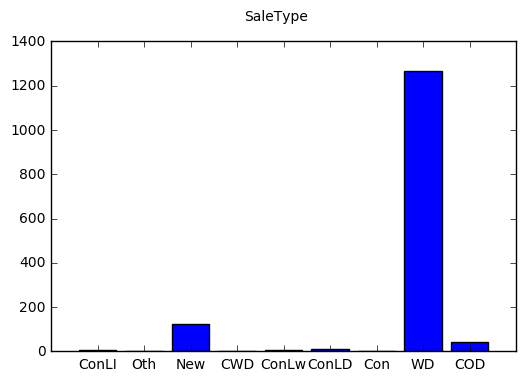

Fence


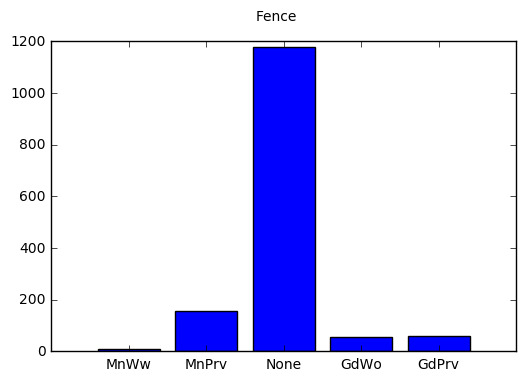

SaleCondition


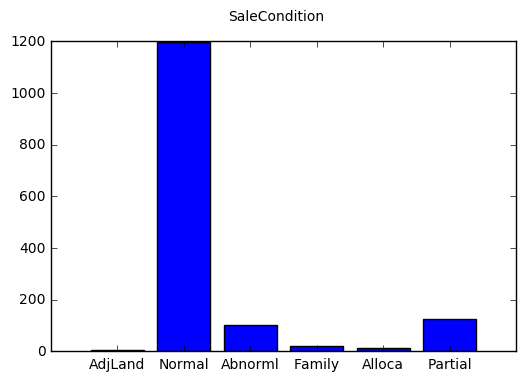

LotConfig


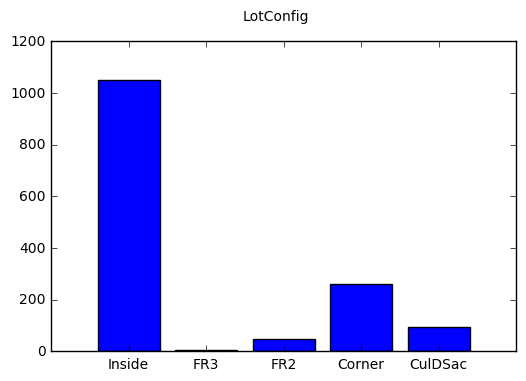

PavedDrive


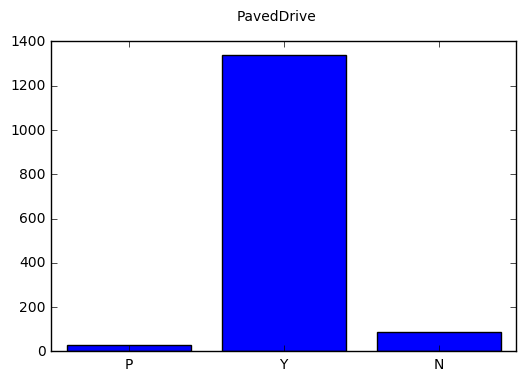

CentralAir


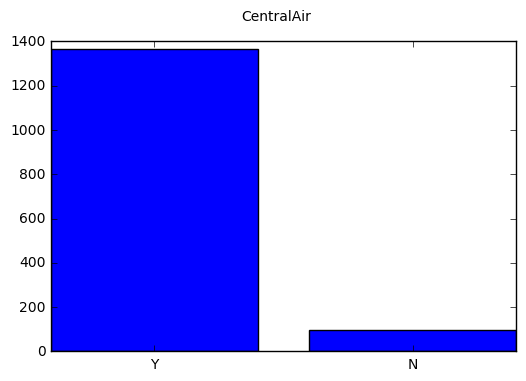

Condition1


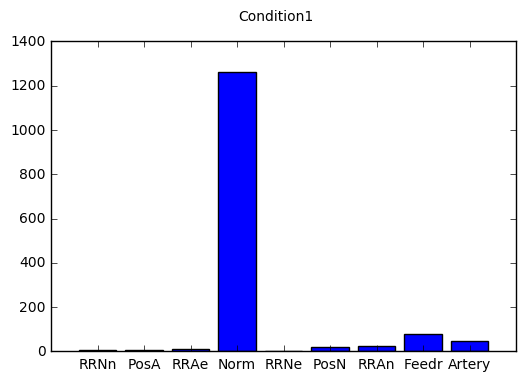

RoofMatl


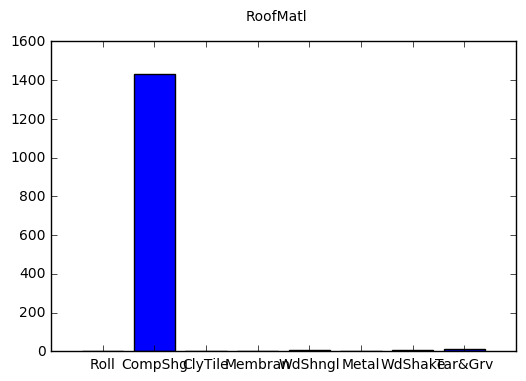

BsmtExposure


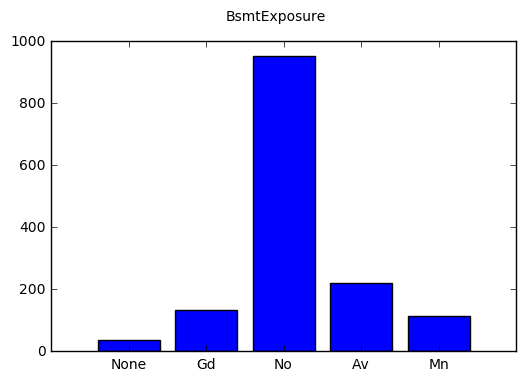

Foundation


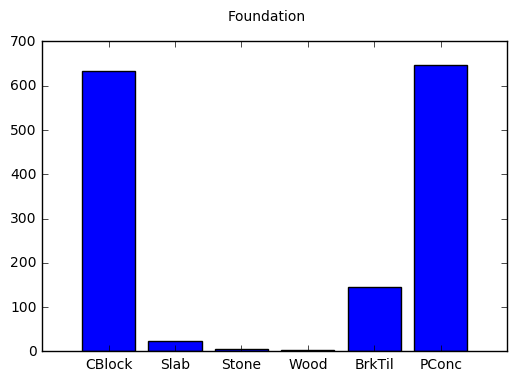

BldgType


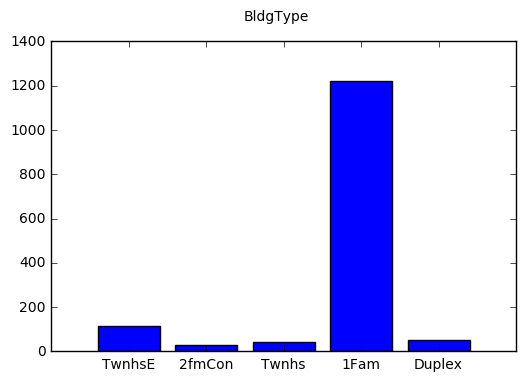

Alley


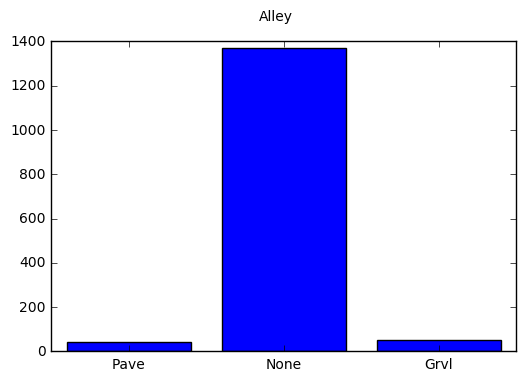

LandContour


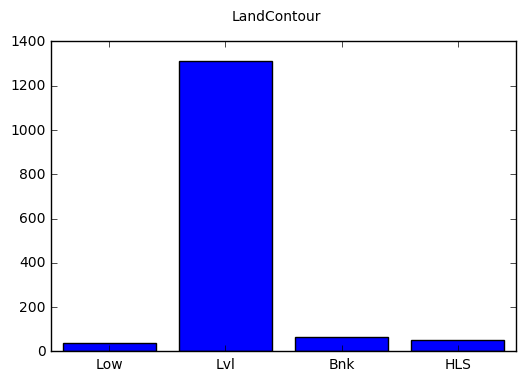

GarageQual


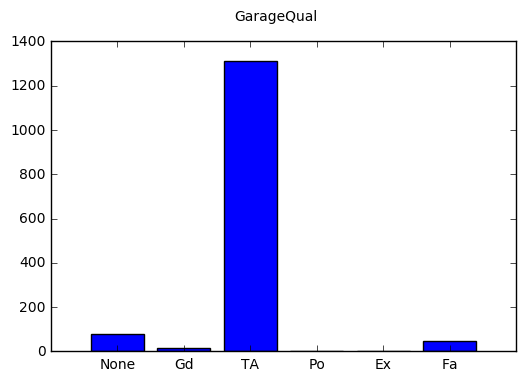

Heating


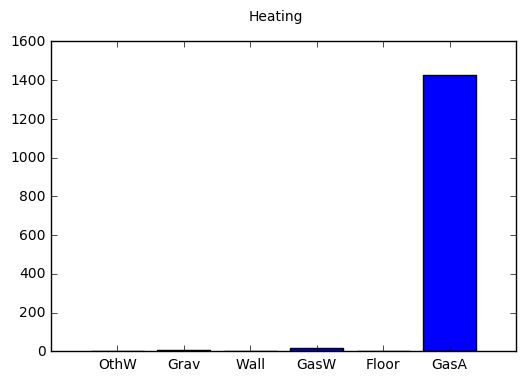

Functional


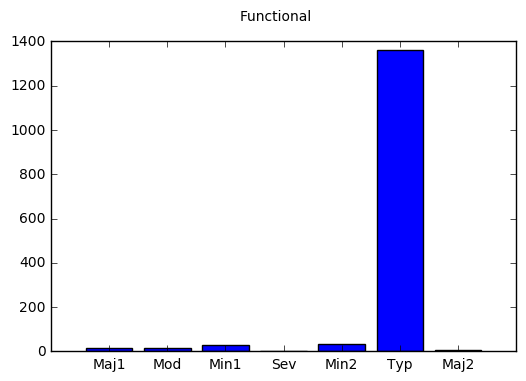

ExterCond


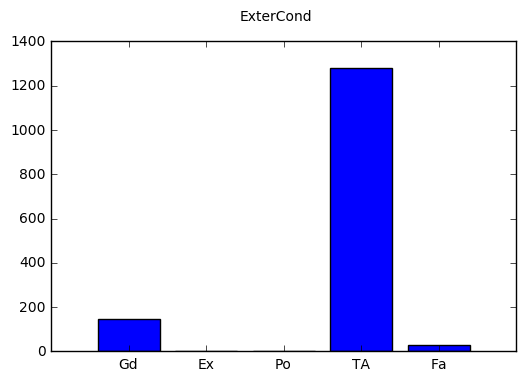

MSZoning


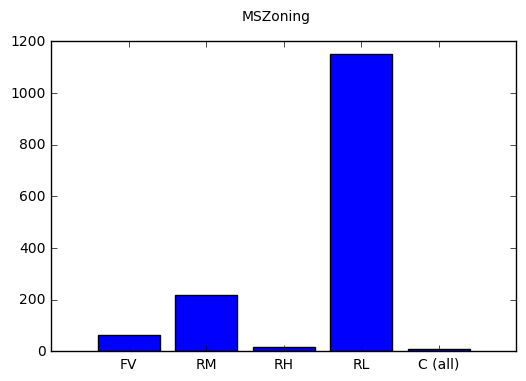

BsmtFinType1


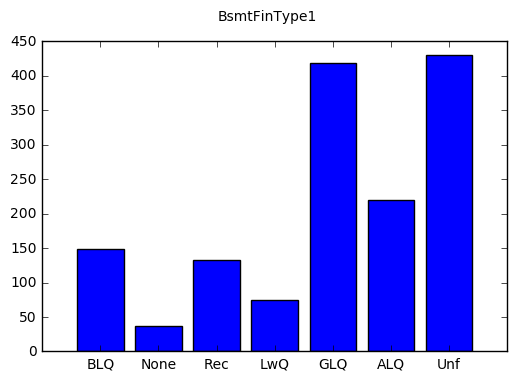

MiscFeature


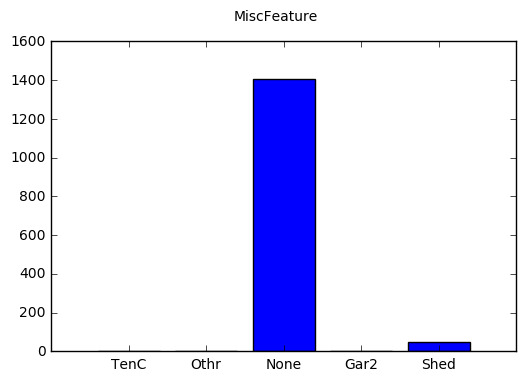

HeatingQC


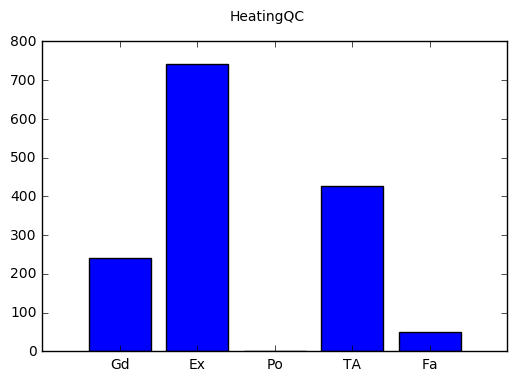

MasVnrType


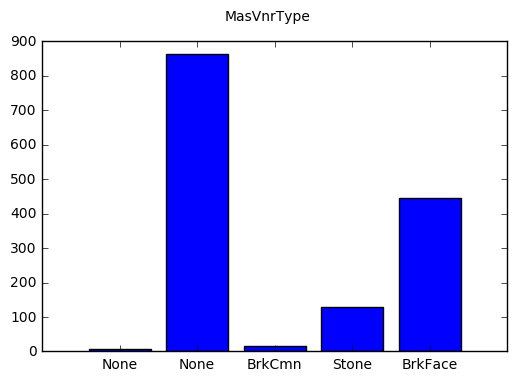

Neighborhood


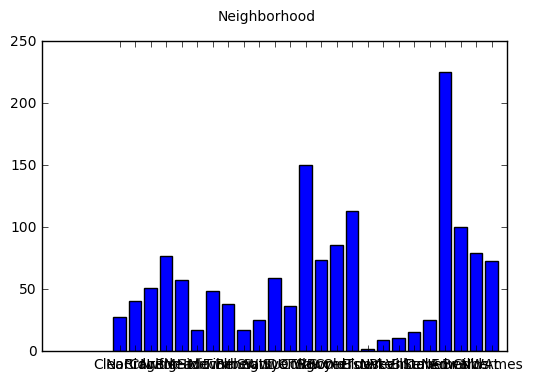

BsmtFinType2


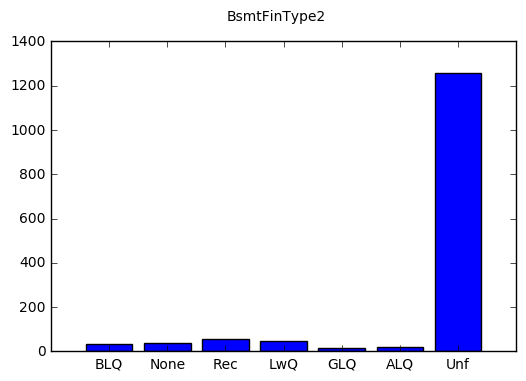

Utilities


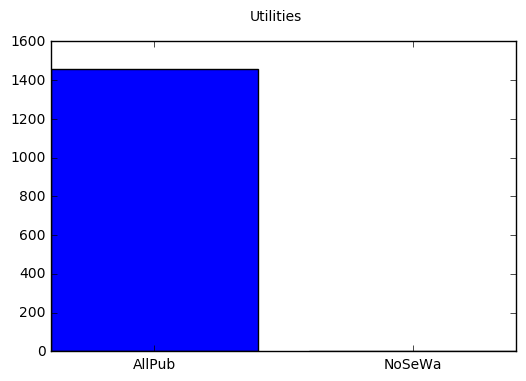

ExterQual


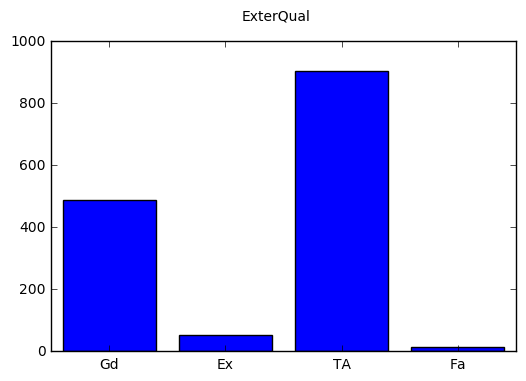

HouseStyle


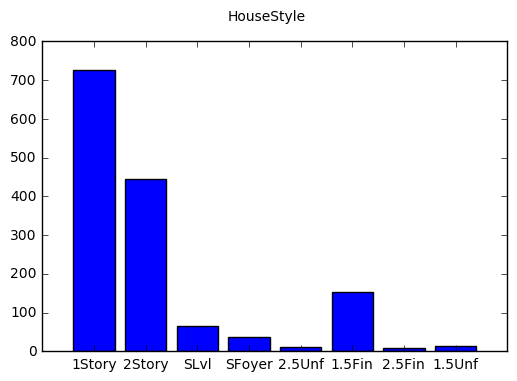

FireplaceQu


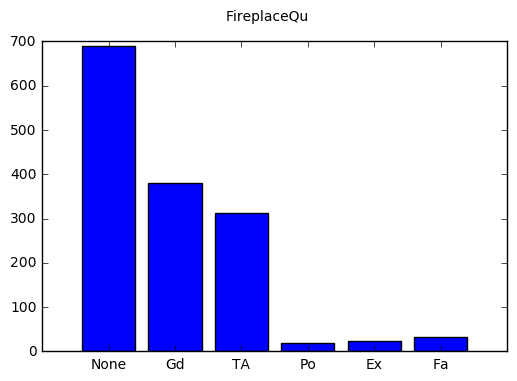

Exterior1st


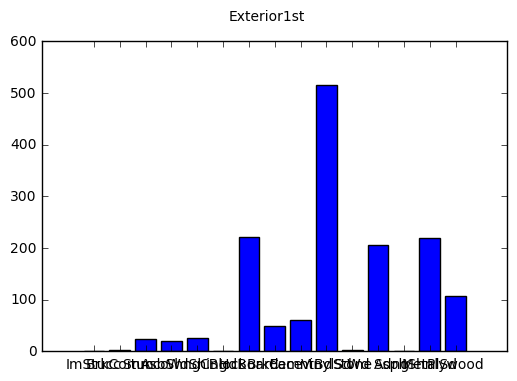

In [7]:
for c in var_cat:
    print(c)
    bar_plot(c,c,data=datos)

In [8]:
spark.stop()